In [1]:
import cudaq
from cudaq import spin
import numpy as np
from math import pi
from typing import List
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
cudaq.register_operation("custom_a", np.array(
    [[0, 1], 
     [0, 0]]
))

In [3]:
cudaq.set_target("orca-photonics")
@cudaq.kernel
def kernel():
    q = qudit(2)
    # h(q)
    # annihilate(q)
    # create(q)

    mz(q)

In [4]:
cudaq.set_target("nvidia")
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)
    # h(q)
    # custom_a(q[0])
    # y(q)
    x(q)
    rz(0.25*pi, q)

In [5]:
shot = int(1e6)
result = cudaq.sample(kernel, shots_count=shot)

print(result)

{ 11:1000000 }



In [6]:
state = cudaq.get_state(kernel)
a = state.amplitudes(["00","11"])
a = np.array(a, dtype=np.complex128)
print(abs(a))
print(a)

[0.         0.99999998]
[0.        +0.j         0.70710671+0.70710683j]


In [7]:
c = np.array([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.], dtype=cudaq.complex())
@cudaq.kernel
def kk(cc: List[complex]):
    # a = cudaq.qvector([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.])
    a = cudaq.qvector(cc)
    # a = cudaq.qvector([0.+0j, 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

    # h(a)
    # exp_pauli(3.14 / 4, a, "IXIX")
    # exp_pauli(3.14 / 4, a, "IYIY")
    
result = cudaq.sample(kk, c, shots_count=int(1e5))
print(result)
print(cudaq.draw(kk, c))

{ 0001:33240 0100:33674 1000:33086 }




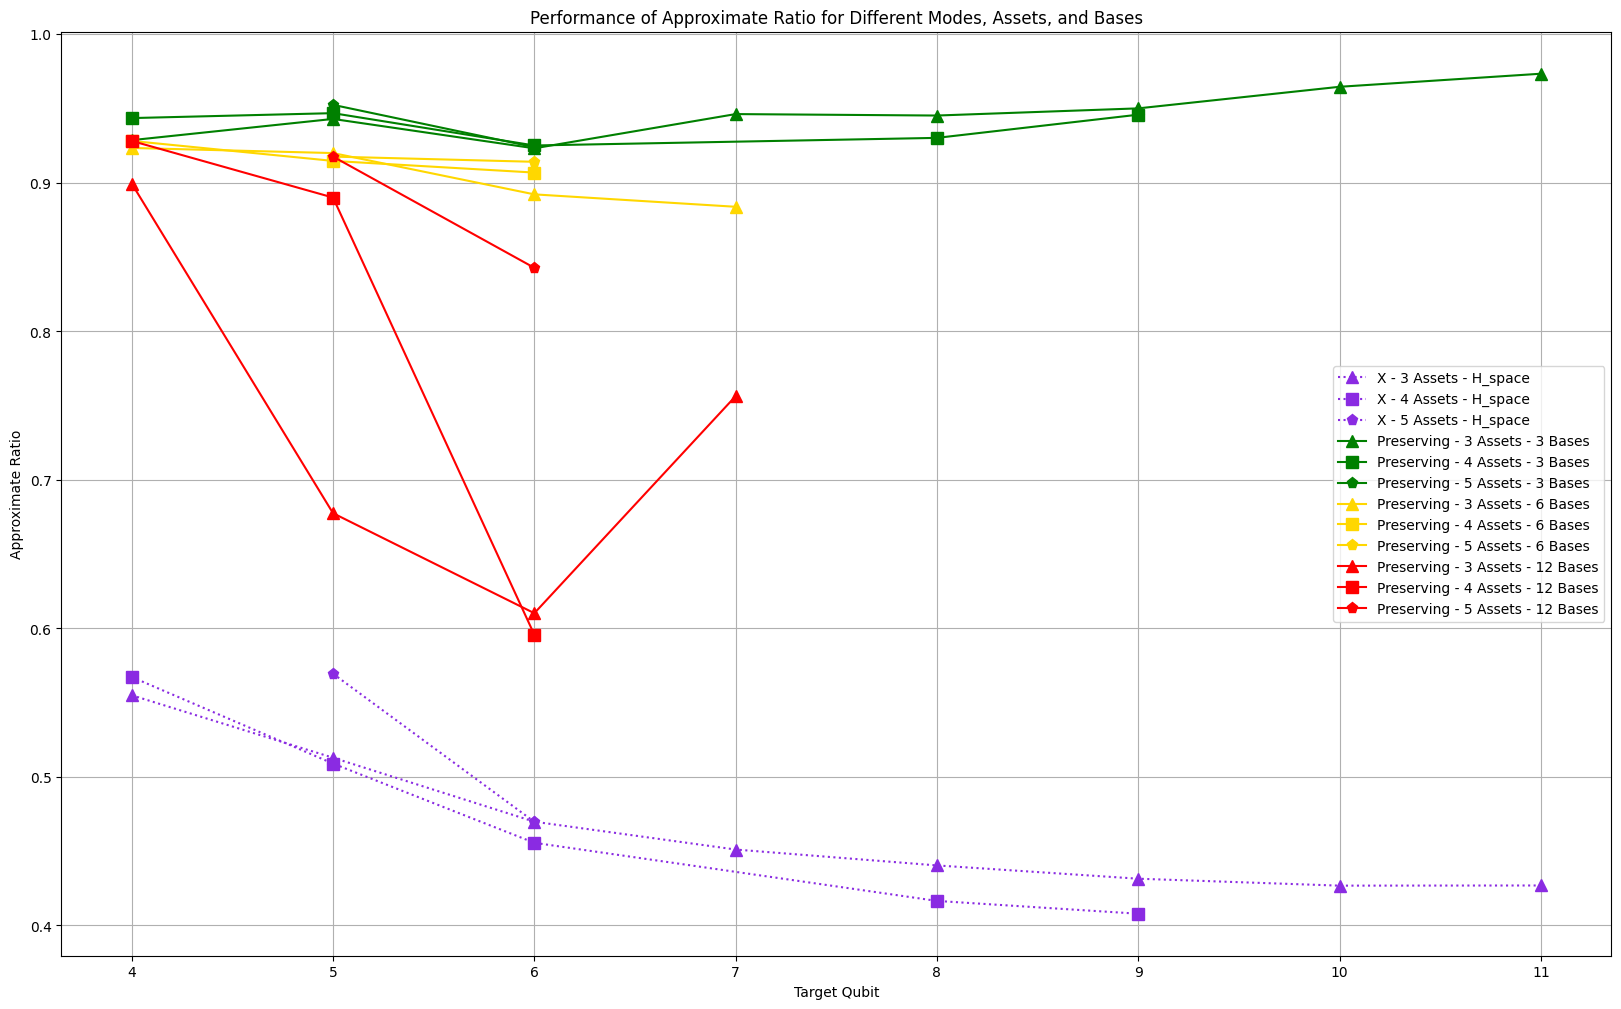

In [9]:
modes = ["X", "Preserving"]
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {(3, 'Preserving'): "green", (3, 'X'): "royalblue",
                (6, 'Preserving'): "gold", (6, 'X'): "orange",
                (12, 'Preserving'): "red", (12, 'X'): "limegreen",
                ("H_space", "X"): "blueviolet"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = ["Approximate_ratio", "MaxProb_ratio"][0]
plt.figure(figsize=(20, 12))
for mode in modes:
    for num_init_bases in (["H_space"] if mode == "X" else [3, 6, 12]):
        for N_ASSETS in range(3, 6):
            mode_results = []
            range_qubit = []
            for TARGET_QUBIT in range(4, 12):
                dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{3 if mode == 'X' else num_init_bases}"
                dir_path = f"./experiments/{dir_name}"
                if not os.path.exists(f"{dir_path}/result.csv"):
                    continue
                df = pd.read_csv(f"{dir_path}/result.csv")
                mode_result = df[df["Mode"] == mode][plot_mode].values[0]
                mode_results.append(mode_result)
                range_qubit.append(TARGET_QUBIT)
            plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
plt.xlabel("Target Qubit")
plt.ylabel(plot_mode.replace("_", " ").title())
plt.title(f"Performance of {plot_mode.replace('_', ' ').title()} for Different Modes, Assets, and Bases")
plt.legend()
plt.grid()
plt.show()